In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path

import plotly.figure_factory as ff
import plotly.io as pio

import sklearn
from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer

import spacy
from spacy.lang.en import STOP_WORDS

import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
toefl = pd.read_csv('toefl.csv')

icle = pd.read_csv('icle_toefl_tagged_readability.csv')

In [4]:
toefl.head()

,Unnamed: 0,Filename,text,Language,Proficiency,pos,readability_words,readability_sents
0,0,88.txt,Some people might think that traveling in a gr...,KOR,high,DET NOUN AUX VERB SCONJ VERB ADP DET NOUN VERB...,3.695962,23.388889
1,1,278.txt,IThe importance and popularity of travelling i...,DEU,medium,DET NOUN CCONJ NOUN ADP VERB AUX ADV VERB PUNC...,3.829480,23.066667
2,2,348.txt,"It is an important decision, how to plan your ...",TUR,high,PRON AUX DET ADJ NOUN PUNCT SCONJ PART VERB PR...,4.126551,25.187500
3,3,666.txt,Some people believe that young people can enjo...,ZHO,medium,DET NOUN VERB SCONJ ADJ NOUN AUX VERB NOUN ADJ...,3.812808,15.037037
4,4,733.txt,Travelling is usually considered as good recr...,TEL,medium,NOUN AUX SPACE ADV VERB ADP ADJ NOUN SPACE ADP...,4.072581,26.571429


In [5]:
icle.head()

,Unnamed: 0,Unnamed: 0.1,File_name,Native_language,Country,Gender,Age,1st_FL,2nd_FL,3rd_FL,...,Length_in_words,Type,Conditions,Reference_tools,Examination,Comments,Text,pos,readability_words,readability_sents
0,0,0,FRUC2027,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,896,Literary,Timed,Yes,Yes,-,Different ways of managing kinds of wastes ar...,SPACE ADJ NOUN ADP VERB NOUN ADP NOUN AUX VERB...,4.380634,20.655172
1,1,1,FRUC2028,FRA,Belgium,Female,20.0,NaN,NaN,NaN,...,657,Literary,Timed,Yes,Yes,-,"Nowadays, people around the world pay more at...",SPACE ADV PUNCT NOUN ADP DET NOUN VERB ADJ NOU...,4.502755,22.000000
2,2,2,FRUC2029,FRA,Belgium,Female,22.0,German,Dutch,NaN,...,712,Literary,Timed,Yes,Yes,-,There are a million of trush produced by Hong...,SPACE PRON VERB DET NUM ADP NOUN VERB ADP PROP...,4.303290,16.642857
3,3,3,FRUC2030,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,652,Literary,Timed,Yes,Yes,-,"In Hong Kong, majority of waste management is...",SPACE ADP PROPN PROPN PUNCT NOUN ADP NOUN NOUN...,4.421898,20.147059
4,4,4,FRUC2032,FRA,Belgium,Female,20.0,Dutch,NaN,NaN,...,1870,Literary,Timed,Yes,Yes,-,There are various way for treating waste mate...,SPACE PRON VERB ADJ NOUN ADP VERB NOUN NOUN AD...,4.519525,18.406250


In [6]:
desired_languages = ['JPN', 'DEU', 'KOR', 'ZHO', 'SPA', 'TUR', 'ITA', 'FRA']
toefl = toefl[toefl['Language'].isin(desired_languages)]

In [7]:
toefl.text.replace(r'\n+',' ', regex=True, inplace=True)
icle.Text.replace(r'\n+', ' ', regex=True, inplace=True)

In [8]:
X_toefl = toefl.drop(columns=['Unnamed: 0', 'Filename', 'Language', 'Proficiency'])
y_toefl = toefl.Language

X_icle = icle.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'File_name', 'Native_language', 'Country', 'Gender', 'Age', '1st_FL', '2nd_FL', '3rd_FL', '1st_Lhome',
                     '2nd_Lhome', '3rd_Lhome', 'Years_Eng_school', 'Years_Eng_uni','Months_in_Eng_country', 'Institution',
                     'Topic', 'Length_in_words', 'Type', 'Conditions', 'Reference_tools', 'Examination', 'Comments'])
X_icle = X_icle.rename(columns={'Text':'text'})
y_icle = icle.Native_language
# Split the data into train, dev, and test sets
X_train_icle, X_test_icle, y_train_icle, y_test_icle = train_test_split(X_icle, y_icle, shuffle=True, stratify = y_icle, random_state=42, test_size=.1)

## Random Forest + NLP

In [9]:
# Create the scaler, vectorizers, and preprocessor
scaler = StandardScaler()
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), lowercase=False, tokenizer=str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1, 4), lowercase=False, tokenizer=str.split)

preprocessor = make_column_transformer(
    (scaler, ['readability_words', 'readability_sents']),
    (vect1, 'text'),
    (vect2, 'pos'),
    remainder='drop'
)

# Create the Random Forest classifier
rf_clf = RandomForestClassifier(max_depth=50, n_estimators=100, random_state=42, max_features='auto')

# Create the pipeline with the preprocessor and Random Forest classifier
pipe = make_pipeline(preprocessor, rf_clf)

# Fit the pipeline on the training data
pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['readability_words',
                                                   'readability_sents']),
                                                 ('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text'),
                                                 ('tfidfvectorizer-2',
                                 

### ICLE in-corpus + NLP

              precision    recall  f1-score   support

         DEU       0.56      0.82      0.67        45
         FRA       0.67      0.52      0.58        31
         ITA       0.83      0.88      0.85        40
         JPN       0.84      0.70      0.76        37
         KOR       0.69      0.78      0.73        40
         SPA       0.73      0.32      0.44        25
         TUR       0.89      0.55      0.68        29
         ZHO       0.81      0.90      0.85        98

    accuracy                           0.74       345
   macro avg       0.75      0.68      0.70       345
weighted avg       0.76      0.74      0.74       345



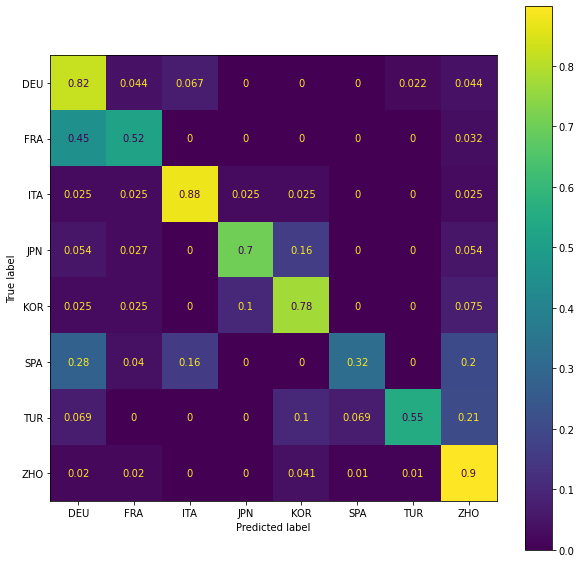

In [10]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### TOEFL cross-corpus + NLP

              precision    recall  f1-score   support

         DEU       0.21      0.78      0.33      1100
         FRA       0.39      0.02      0.03      1100
         ITA       0.36      0.05      0.09      1100
         JPN       0.39      0.37      0.38      1100
         KOR       0.31      0.47      0.38      1100
         SPA       0.46      0.01      0.03      1100
         TUR       0.50      0.03      0.05      1100
         ZHO       0.26      0.39      0.31      1100

    accuracy                           0.27      8800
   macro avg       0.36      0.27      0.20      8800
weighted avg       0.36      0.27      0.20      8800



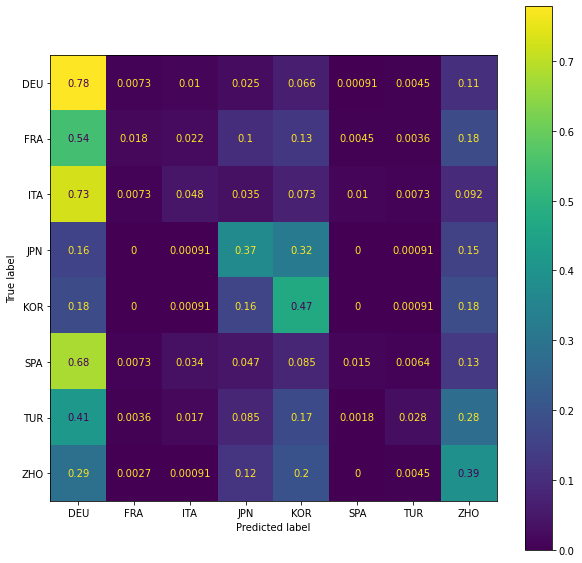

In [11]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Random Forest + NLP - POS

In [12]:
# Create the scaler, vectorizers, and preprocessor
scaler = StandardScaler()
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), lowercase=False, tokenizer=str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1, 4), lowercase=False, tokenizer=str.split)

preprocessor = make_column_transformer(
    (scaler, ['readability_words', 'readability_sents']),
    (vect1, 'text'),
#     (vect2, 'pos'),
    remainder='drop'
)

# Create the Random Forest classifier
rf_clf = RandomForestClassifier(max_depth=50, n_estimators=100, random_state=42, max_features='auto')

# Create the pipeline with the preprocessor and Random Forest classifier
pipe = make_pipeline(preprocessor, rf_clf)

# Fit the pipeline on the training data
pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['readability_words',
                                                   'readability_sents']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text')])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=50, random

### ICLE in-corpus Random Forest + NLP - POS

              precision    recall  f1-score   support

         DEU       0.60      0.89      0.71        45
         FRA       0.71      0.55      0.62        31
         ITA       0.90      0.88      0.89        40
         JPN       0.87      0.70      0.78        37
         KOR       0.77      0.93      0.84        40
         SPA       0.79      0.44      0.56        25
         TUR       0.90      0.62      0.73        29
         ZHO       0.86      0.91      0.89        98

    accuracy                           0.79       345
   macro avg       0.80      0.74      0.75       345
weighted avg       0.81      0.79      0.79       345



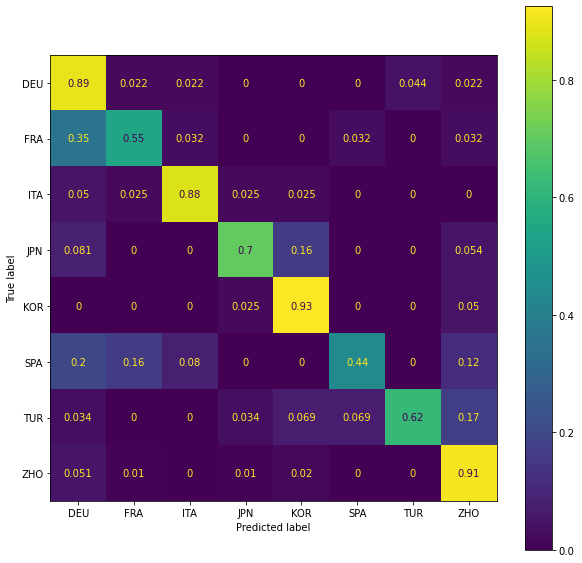

In [13]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### TOEFL cross-corpus Random Forest + NLP - POS

              precision    recall  f1-score   support

         DEU       0.20      0.74      0.31      1100
         FRA       0.74      0.02      0.04      1100
         ITA       0.33      0.01      0.02      1100
         JPN       0.48      0.25      0.33      1100
         KOR       0.24      0.75      0.36      1100
         SPA       0.45      0.00      0.01      1100
         TUR       0.48      0.03      0.06      1100
         ZHO       0.36      0.17      0.23      1100

    accuracy                           0.25      8800
   macro avg       0.41      0.25      0.17      8800
weighted avg       0.41      0.25      0.17      8800



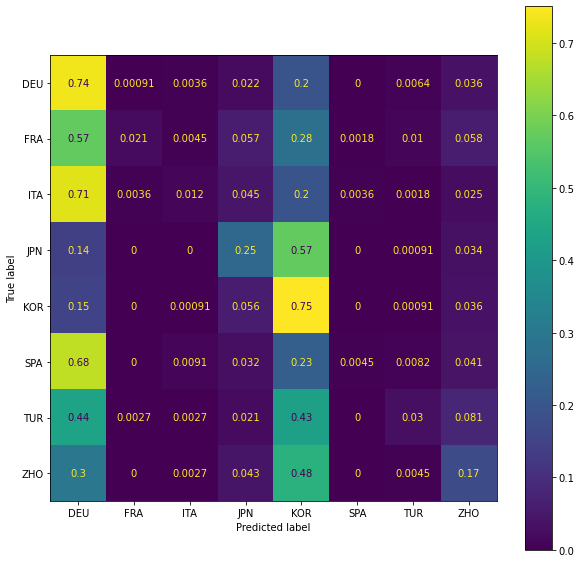

In [14]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Random Forest + NLP - Complexity

In [15]:
# Create the scaler, vectorizers, and preprocessor
scaler = StandardScaler()
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), lowercase=False, tokenizer=str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1, 4), lowercase=False, tokenizer=str.split)

preprocessor = make_column_transformer(
#     (scaler, ['readability_words', 'readability_sents']),
    (vect1, 'text'),
    (vect2, 'pos'),
    remainder='drop'
)

# Create the Random Forest classifier
rf_clf = RandomForestClassifier(max_depth=50, n_estimators=100, random_state=42, max_features='auto')

# Create the pipeline with the preprocessor and Random Forest classifier
pipe = make_pipeline(preprocessor, rf_clf)

# Fit the pipeline on the training data
pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=200,
                                                                  ngram_range=(1,
                                                                  

### ICLE in-corpus Random Forest + NLP - Complexity

              precision    recall  f1-score   support

         DEU       0.57      0.87      0.69        45
         FRA       0.70      0.52      0.59        31
         ITA       0.73      0.82      0.78        40
         JPN       0.85      0.62      0.72        37
         KOR       0.71      0.88      0.79        40
         SPA       0.89      0.32      0.47        25
         TUR       0.74      0.48      0.58        29
         ZHO       0.86      0.92      0.89        98

    accuracy                           0.75       345
   macro avg       0.76      0.68      0.69       345
weighted avg       0.77      0.75      0.74       345



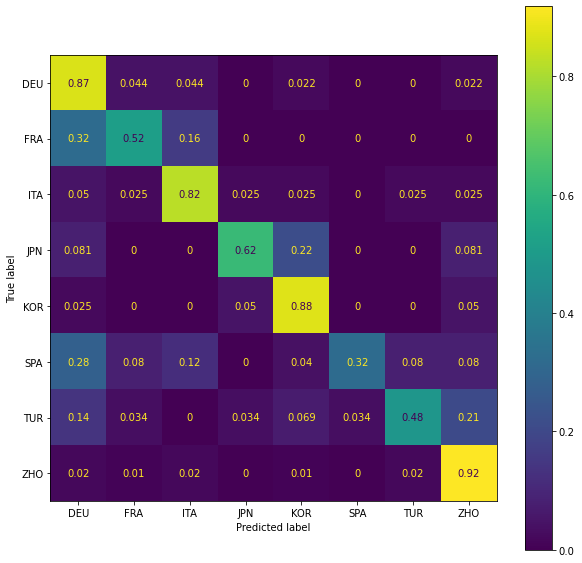

In [16]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### TOEFL cross-corpus Random Forest + NLP - Complexity

              precision    recall  f1-score   support

         DEU       0.21      0.74      0.32      1100
         FRA       0.53      0.02      0.03      1100
         ITA       0.34      0.06      0.10      1100
         JPN       0.38      0.33      0.36      1100
         KOR       0.28      0.55      0.37      1100
         SPA       0.25      0.01      0.01      1100
         TUR       0.28      0.02      0.04      1100
         ZHO       0.27      0.35      0.30      1100

    accuracy                           0.26      8800
   macro avg       0.32      0.26      0.19      8800
weighted avg       0.32      0.26      0.19      8800



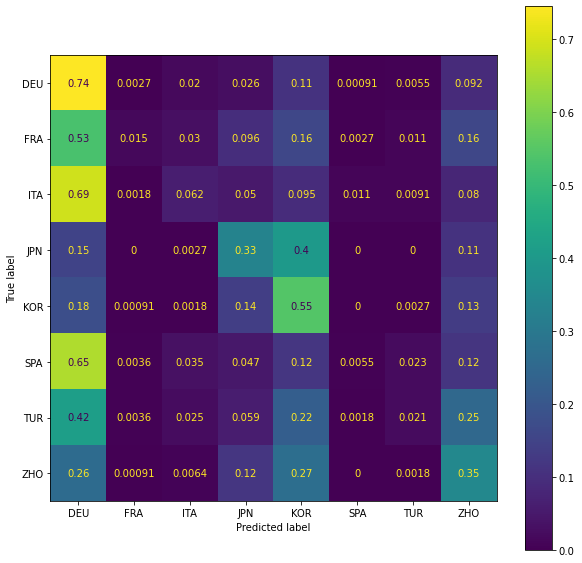

In [17]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Random Forest - NLP

In [18]:
# Create the scaler, vectorizers, and preprocessor
scaler = StandardScaler()
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), lowercase=False, tokenizer=str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1, 4), lowercase=False, tokenizer=str.split)

preprocessor = make_column_transformer(
#     (scaler, ['readability_words', 'readability_sents']),
    (vect1, 'text'),
#     (vect2, 'pos'),
    remainder='drop'
)

# Create the Random Forest classifier
rf_clf = RandomForestClassifier(max_depth=50, n_estimators=100, random_state=42, max_features='auto')

# Create the pipeline with the preprocessor and Random Forest classifier
pipe = make_pipeline(preprocessor, rf_clf)

# Fit the pipeline on the training data
pipe.fit(X_train_icle, y_train_icle)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text')])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=50, random_state=42))])

### ICLE in-corpus Random Forest - NLP

              precision    recall  f1-score   support

         DEU       0.60      0.87      0.71        45
         FRA       0.68      0.55      0.61        31
         ITA       0.89      0.85      0.87        40
         JPN       0.77      0.65      0.71        37
         KOR       0.75      0.82      0.79        40
         SPA       0.80      0.48      0.60        25
         TUR       0.82      0.62      0.71        29
         ZHO       0.83      0.89      0.86        98

    accuracy                           0.77       345
   macro avg       0.77      0.72      0.73       345
weighted avg       0.78      0.77      0.76       345



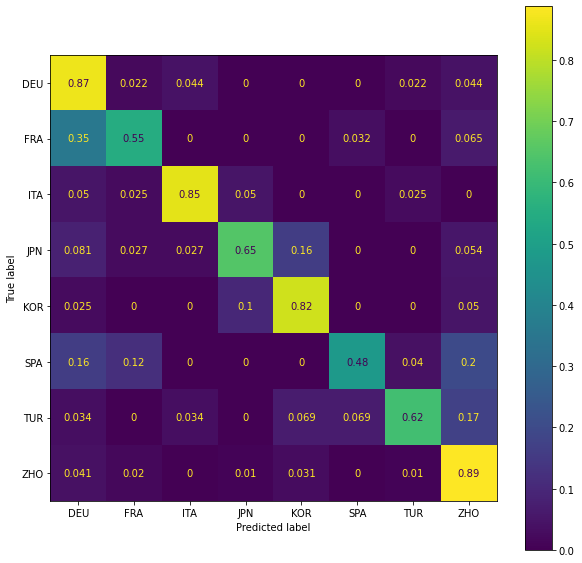

In [19]:
y_icle_pred = pipe.predict(X_test_icle)

print(classification_report(y_test_icle, y_icle_pred))

cm = confusion_matrix(y_test_icle, y_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### TOEFL cross-corpus Random Forest - NLP

              precision    recall  f1-score   support

         DEU       0.21      0.80      0.34      1100
         FRA       0.68      0.02      0.03      1100
         ITA       0.31      0.00      0.01      1100
         JPN       0.53      0.20      0.29      1100
         KOR       0.25      0.79      0.37      1100
         SPA       0.44      0.00      0.01      1100
         TUR       0.53      0.04      0.07      1100
         ZHO       0.35      0.19      0.25      1100

    accuracy                           0.25      8800
   macro avg       0.41      0.25      0.17      8800
weighted avg       0.41      0.25      0.17      8800



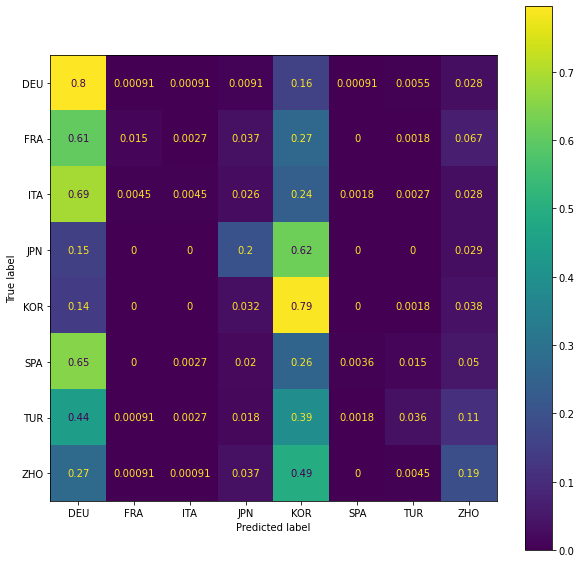

In [20]:
y_toefl_pred = pipe.predict(X_toefl)

print(classification_report(y_toefl, y_toefl_pred))

cm = confusion_matrix(y_toefl, y_toefl_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)